In [2]:
import zipfile
import shutil
import numpy as np
import matplotlib.pyplot as plt
# sphinx_gallery_thumbnail_path = '_static/playback-thumbnail.png'

import librosa
import librosa.display

# We'll need IPython.display's Audio widget
from IPython.display import Audio

# We'll also use `mir_eval` to synthesize a signal for us
import mir_eval.sonify

import pandas as pd
import csv
import os
import json
import scipy



## Pitch Class Profile

Os acordes são unicamente formados por um conjunto de notas individuais. Cada uma das 12 notas da escala cromática possui uma frequência única e podemos mapear a intensidade que essas frequências estão presentes nos aúdios utilizando um algoritmo chamado Pitch Class Profile.

In [4]:
df = pd.read_csv('metadata_freqv2.csv', sep = ',')
df_chords = df[df['most_freq'] == 1]

#df_chords = df


most_freq = df_chords['Acorde'].unique()

## paths

audio_fpath = 'processed_audio/'
audio_clips = df_chords['Filename']


show_filenames = []
# Recuperando um caso de cada acorde, para comparar os espectogramas
for i in most_freq:
    filename = df_chords.loc[df_chords['Acorde'] == i]['Filename'].iloc[0,]
    show_filenames.append(filename)

In [9]:
len(show_filenames)

12

In [5]:
def PCP(filepath, sr = 44100, filters = True):
    ''' 
    Converte o aúdio em um espectograma (cromagrama) 
    filepath (str) : caminho para o arquivo .wav 
    filters (boolean) : se deseja aplicar ou não os filtros no espectograma gerado
    
    '''

    y, sr = librosa.load(filepath, sr=sr)

    CQT = np.abs(librosa.cqt(y, sr=sr))
    chroma_map = librosa.filters.cq_to_chroma(CQT.shape[0], n_chroma = 12)
    chromagram = chroma_map.dot(CQT)

    # Max-normalize each time step

    chromagram = librosa.util.normalize(chromagram, axis=0)

    ydb = librosa.amplitude_to_db(CQT,ref=np.max)

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)

    if filters == True:
        chroma_min = np.minimum(chroma,
                           librosa.decompose.nn_filter(chroma,
                                                       aggregate=np.median,
                                                       metric='cosine'))

        chroma_smooth = scipy.ndimage.median_filter(chroma_min, size=(1, 9))

        return chroma_smooth
    
    

    return chroma
    

O primeiro gráfico representa o espectograma gerado pelo algoritmo Pitch Class Profile, veja que o eixo y representa cada uma das notas da escala cromática. Quanto mais clara as linhas na frente dessas notas, maior a intensidade delas no áudio. Veja que no caso do acorde C, as regiões referentes as notas C, G e E tem maior intensidade.

C:maj


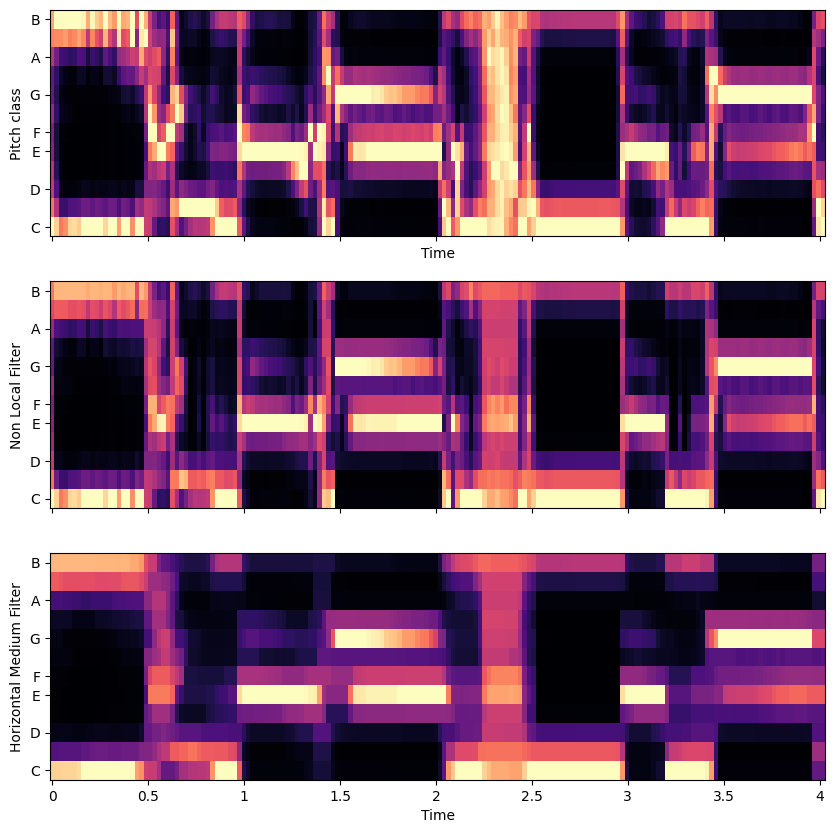

In [12]:
file = audio_fpath + show_filenames[11]
chord = most_freq[11]
chroma = PCP(file, filters = False)
chroma_min = chroma_filter = np.minimum(chroma,
                           librosa.decompose.nn_filter(chroma,
                                                       aggregate=np.median,
                                                       metric='cosine'))

chroma_smooth = scipy.ndimage.median_filter(chroma_min, size=(1, 9))



fig, ax = plt.subplots(nrows=3, sharex=True, sharey=True, figsize=(10, 10))

print(chord)
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax[0])
ax[1].set(ylabel='Default chroma')
ax[1].label_outer()

librosa.display.specshow(chroma_min, y_axis='chroma', x_axis='time', ax=ax[1])
ax[1].set(ylabel='Non Local Filter')
ax[1].label_outer()

librosa.display.specshow(chroma_smooth, y_axis='chroma', x_axis='time', ax=ax[2])
ax[2].set(ylabel='Horizontal Medium Filter')
ax[2].label_outer()



Os outros gráfico apresentam alguns filtros de suavização aplicados no áudio para remoção do ruído. Na prática os filtros tendem a ser mais úteis no áudios que serão enviados no dashboard, uma vez que a base de dados possui gravações limpas e de alta qualidade dos acordes.

Aplicando o processamento para alguns acordes disponíveis na base de dados:

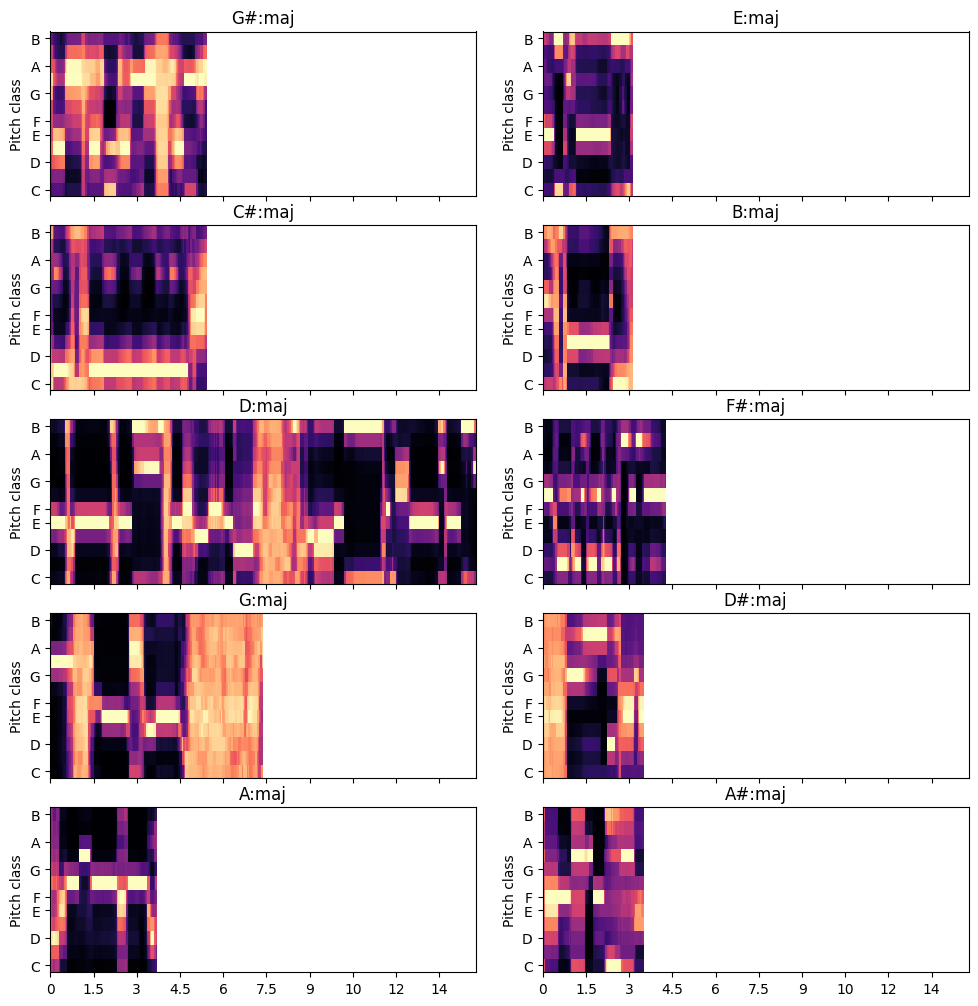

In [13]:
chromas = [PCP(audio_fpath + i) for i in show_filenames ]

fig, ax = plt.subplots(nrows=5, ncols=2, sharex=True, figsize=(10, 10))
fig.tight_layout()
for i in range(0, 2):
    if i == 0:
        up = 0
    else:
        up = 5
    for k in range(len(ax)):
        imgchroma = librosa.display.specshow(chromas[k+up], y_axis='chroma', x_axis = 'time', ax=ax[k,i])

        ax[k,i].set(title=most_freq[k+up])
        ax[k,i].set_xlabel('')


## Iterando para todos os aúdios

Agora iteramos o processo de criação de espectograma para todos os áudios do conjunto de dados. O processo demora cerca de 5 minutos.

In [6]:
def get_label(filepath):
    '''
    Dado o arquivo do acorde, recupera a nomenclatura deste

    Args:
    filepath (str): caminho para o arquivo .wav (arquivos dentro da pasta preprocessed_audio/)
    '''

    metadata = pd.read_csv('metadata_freq.csv', sep = ',')
    chords = {}

    filename = filepath.split('/')[1]
    chord = metadata[metadata['Filename'] == filename]['Acorde'].values[0]

    return chord

In [8]:
filepaths = audio_fpath + df_chords['Filename']

features = []
labels = []
n_mels = 40
frames_max = 0

from tqdm import tqdm
for i in tqdm(filepaths):
    pcp = PCP(i)
    num_frames = pcp.shape[1]
    features.append(pcp)
    labels.append(get_label(i))

    if (num_frames > frames_max):
        frames_max = num_frames

  0%|          | 0/1320 [00:00<?, ?it/s]

100%|██████████| 1320/1320 [03:09<00:00,  6.98it/s]


Como tempos áudios de diferentes durações, é necessário definir a duração máxima encontrada no conjunto de dados e preencher com zeros os áudios mais curtos. Esse procedimento garante que seremos capazes de usar os espectogramas gerados nos modelos de classificação.

In [9]:
# Given an numpy array of features, zero-pads each ocurrence to max_padding
def add_padding(features, max_padding=174):
    padded = []

    # Add padding
    for i in range(len(features)):
        px = features[i]
        size = len(px[0])
        # Add padding if required
        if (size < max_padding):
            xDiff = max_padding - size
            xLeft = xDiff//2
            xRight = xDiff-xLeft
            px = np.pad(px, pad_width=((0,0), (xLeft, xRight)), mode='constant')
        
        padded.append(px)

    return padded


padded_features = add_padding(features, frames_max)

Salvamos as representações no vetor "X_PCP_FREQ2.npy" e os respectivos acordes em "y_PCP_FREQ2.npy"

In [10]:
X = np.array(padded_features)
y = np.array(labels)

np.save("X_PCP_FREQ2.npy", X)
np.save("y_PCP_FREQ2.npy", y)